## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=6400, bias=True)
  (fc2): Linear(in_features=6400, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=136, bias=True)
  (dropout1_2): Dropout(p=0.1, inplace=False)
  (dropout3_4_5): Dropout(p=0.3, inplace=False)
  (dropout6_7): Dropout(p=0.5, inplace=False)
)


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 50

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

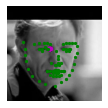

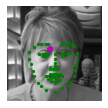

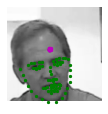

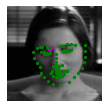

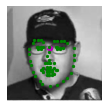

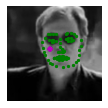

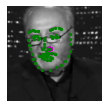

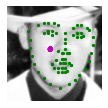

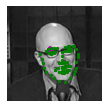

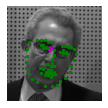

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters())


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
import time

def train_net(n_epochs):

    # prepare the net for training
    net.to(device)
    net.train()
    
    start_time = time.time()
    loss_list = []
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image'].to(device)
            key_pts = data['keypoints'].to(device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            
            print_every = 10
            if batch_i % print_every == 9:    # print every 10 batches
                avg_running_lost = running_loss/print_every
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_running_lost))
                loss_list.append(avg_running_lost)
                running_loss = 0.0

    print('Finished Training in {} seconds'.format(time.time() - start_time))
    
    plt.figure(figsize=(20,10))
    plt.plot(loss_list)


Epoch: 1, Batch: 10, Avg. Loss: 0.22849791049957274
Epoch: 1, Batch: 20, Avg. Loss: 0.10787186026573181
Epoch: 1, Batch: 30, Avg. Loss: 0.10231253802776337
Epoch: 1, Batch: 40, Avg. Loss: 0.08992133140563965
Epoch: 1, Batch: 50, Avg. Loss: 0.09071615636348725
Epoch: 1, Batch: 60, Avg. Loss: 0.09670418053865433
Epoch: 1, Batch: 70, Avg. Loss: 0.09421321675181389
Epoch: 2, Batch: 10, Avg. Loss: 0.1042925164103508
Epoch: 2, Batch: 20, Avg. Loss: 0.10031469613313675
Epoch: 2, Batch: 30, Avg. Loss: 0.09663388282060623
Epoch: 2, Batch: 40, Avg. Loss: 0.09293892383575439
Epoch: 2, Batch: 50, Avg. Loss: 0.09619610607624055
Epoch: 2, Batch: 60, Avg. Loss: 0.09416927248239518
Epoch: 2, Batch: 70, Avg. Loss: 0.08942706286907195
Epoch: 3, Batch: 10, Avg. Loss: 0.09639761224389076
Epoch: 3, Batch: 20, Avg. Loss: 0.09263048022985458
Epoch: 3, Batch: 30, Avg. Loss: 0.08488715887069702
Epoch: 3, Batch: 40, Avg. Loss: 0.09623591974377632
Epoch: 3, Batch: 50, Avg. Loss: 0.09331968650221825
Epoch: 3, Bat

Epoch: 23, Batch: 20, Avg. Loss: 0.026246868446469306
Epoch: 23, Batch: 30, Avg. Loss: 0.021498493663966656
Epoch: 23, Batch: 40, Avg. Loss: 0.018681233376264574
Epoch: 23, Batch: 50, Avg. Loss: 0.019208214618265627
Epoch: 23, Batch: 60, Avg. Loss: 0.017247952800244094
Epoch: 23, Batch: 70, Avg. Loss: 0.022937688603997232
Epoch: 24, Batch: 10, Avg. Loss: 0.024609389808028938
Epoch: 24, Batch: 20, Avg. Loss: 0.020241833105683327
Epoch: 24, Batch: 30, Avg. Loss: 0.02005985174328089
Epoch: 24, Batch: 40, Avg. Loss: 0.016856199875473977
Epoch: 24, Batch: 50, Avg. Loss: 0.024992447160184384
Epoch: 24, Batch: 60, Avg. Loss: 0.017292536236345767
Epoch: 24, Batch: 70, Avg. Loss: 0.018606464751064776
Epoch: 25, Batch: 10, Avg. Loss: 0.021764811500906943
Epoch: 25, Batch: 20, Avg. Loss: 0.021841667778789996
Epoch: 25, Batch: 30, Avg. Loss: 0.016344566270709036
Epoch: 25, Batch: 40, Avg. Loss: 0.025497878435999155
Epoch: 25, Batch: 50, Avg. Loss: 0.02524112304672599
Epoch: 25, Batch: 60, Avg. Los

Epoch: 45, Batch: 10, Avg. Loss: 0.02102450942620635
Epoch: 45, Batch: 20, Avg. Loss: 0.016262858361005782
Epoch: 45, Batch: 30, Avg. Loss: 0.017590517550706862
Epoch: 45, Batch: 40, Avg. Loss: 0.016151959635317327
Epoch: 45, Batch: 50, Avg. Loss: 0.01491234852001071
Epoch: 45, Batch: 60, Avg. Loss: 0.01496593952178955
Epoch: 45, Batch: 70, Avg. Loss: 0.011884010676294566
Epoch: 46, Batch: 10, Avg. Loss: 0.016827333625406025
Epoch: 46, Batch: 20, Avg. Loss: 0.011968107521533966
Epoch: 46, Batch: 30, Avg. Loss: 0.013756765238940715
Epoch: 46, Batch: 40, Avg. Loss: 0.01187555817887187
Epoch: 46, Batch: 50, Avg. Loss: 0.015327519737184048
Epoch: 46, Batch: 60, Avg. Loss: 0.011751979868859053
Epoch: 46, Batch: 70, Avg. Loss: 0.015071212127804757
Epoch: 47, Batch: 10, Avg. Loss: 0.012131248507648707
Epoch: 47, Batch: 20, Avg. Loss: 0.011966949235647917
Epoch: 47, Batch: 30, Avg. Loss: 0.012151786964386702
Epoch: 47, Batch: 40, Avg. Loss: 0.011743770726025105
Epoch: 47, Batch: 50, Avg. Loss:

Epoch: 66, Batch: 70, Avg. Loss: 0.015544926561415196
Epoch: 67, Batch: 10, Avg. Loss: 0.011324656382203101
Epoch: 67, Batch: 20, Avg. Loss: 0.010264667216688395
Epoch: 67, Batch: 30, Avg. Loss: 0.013339151209220291
Epoch: 67, Batch: 40, Avg. Loss: 0.01282208487391472
Epoch: 67, Batch: 50, Avg. Loss: 0.011670623719692231
Epoch: 67, Batch: 60, Avg. Loss: 0.01063552564010024
Epoch: 67, Batch: 70, Avg. Loss: 0.013614313583821059
Epoch: 68, Batch: 10, Avg. Loss: 0.010230788448825478
Epoch: 68, Batch: 20, Avg. Loss: 0.010046296659857035
Epoch: 68, Batch: 30, Avg. Loss: 0.014565069694072008
Epoch: 68, Batch: 40, Avg. Loss: 0.01364826075732708
Epoch: 68, Batch: 50, Avg. Loss: 0.01586938975378871
Epoch: 68, Batch: 60, Avg. Loss: 0.013884170819073916
Epoch: 68, Batch: 70, Avg. Loss: 0.014113701041787862
Epoch: 69, Batch: 10, Avg. Loss: 0.014212805777788162
Epoch: 69, Batch: 20, Avg. Loss: 0.011167253460735082
Epoch: 69, Batch: 30, Avg. Loss: 0.01503602135926485
Epoch: 69, Batch: 40, Avg. Loss: 

Epoch: 88, Batch: 60, Avg. Loss: 0.011302764480933546
Epoch: 88, Batch: 70, Avg. Loss: 0.011767613654956221
Epoch: 89, Batch: 10, Avg. Loss: 0.014955096133053302
Epoch: 89, Batch: 20, Avg. Loss: 0.013525430392473937
Epoch: 89, Batch: 30, Avg. Loss: 0.013414281886070967
Epoch: 89, Batch: 40, Avg. Loss: 0.009959781728684901
Epoch: 89, Batch: 50, Avg. Loss: 0.00965102408081293
Epoch: 89, Batch: 60, Avg. Loss: 0.009949199017137289
Epoch: 89, Batch: 70, Avg. Loss: 0.01077111940830946
Epoch: 90, Batch: 10, Avg. Loss: 0.01049801460467279
Epoch: 90, Batch: 20, Avg. Loss: 0.010348507016897202
Epoch: 90, Batch: 30, Avg. Loss: 0.011411210894584656
Epoch: 90, Batch: 40, Avg. Loss: 0.00998527705669403
Epoch: 90, Batch: 50, Avg. Loss: 0.011416190536692739
Epoch: 90, Batch: 60, Avg. Loss: 0.009424131270498038
Epoch: 90, Batch: 70, Avg. Loss: 0.010085720708593727
Epoch: 91, Batch: 10, Avg. Loss: 0.010434868605807423
Epoch: 91, Batch: 20, Avg. Loss: 0.009861179906874896
Epoch: 91, Batch: 30, Avg. Loss:

Epoch: 110, Batch: 30, Avg. Loss: 0.013991664815694093
Epoch: 110, Batch: 40, Avg. Loss: 0.01187889650464058
Epoch: 110, Batch: 50, Avg. Loss: 0.013438402581959963
Epoch: 110, Batch: 60, Avg. Loss: 0.012593151815235615
Epoch: 110, Batch: 70, Avg. Loss: 0.01394554553553462
Epoch: 111, Batch: 10, Avg. Loss: 0.011192630929872393
Epoch: 111, Batch: 20, Avg. Loss: 0.01597372959367931
Epoch: 111, Batch: 30, Avg. Loss: 0.01441611759364605
Epoch: 111, Batch: 40, Avg. Loss: 0.011069966200739145
Epoch: 111, Batch: 50, Avg. Loss: 0.012655618228018283
Epoch: 111, Batch: 60, Avg. Loss: 0.014562912425026298
Epoch: 111, Batch: 70, Avg. Loss: 0.011705375043675303
Epoch: 112, Batch: 10, Avg. Loss: 0.010618379898369312
Epoch: 112, Batch: 20, Avg. Loss: 0.01452555567957461
Epoch: 112, Batch: 30, Avg. Loss: 0.012230843771249056
Epoch: 112, Batch: 40, Avg. Loss: 0.011039249878376723
Epoch: 112, Batch: 50, Avg. Loss: 0.011341338558122516
Epoch: 112, Batch: 60, Avg. Loss: 0.011486449372023344
Epoch: 112, Bat

Epoch: 131, Batch: 60, Avg. Loss: 0.016208016220480202
Epoch: 131, Batch: 70, Avg. Loss: 0.01066250316798687
Epoch: 132, Batch: 10, Avg. Loss: 0.010183646902441978
Epoch: 132, Batch: 20, Avg. Loss: 0.011448219045996666
Epoch: 132, Batch: 30, Avg. Loss: 0.010701829893514514
Epoch: 132, Batch: 40, Avg. Loss: 0.009553922386839987
Epoch: 132, Batch: 50, Avg. Loss: 0.009945051744580269
Epoch: 132, Batch: 60, Avg. Loss: 0.009284017980098725
Epoch: 132, Batch: 70, Avg. Loss: 0.0104454156011343
Epoch: 133, Batch: 10, Avg. Loss: 0.009187264554202556
Epoch: 133, Batch: 20, Avg. Loss: 0.013225202774628997
Epoch: 133, Batch: 30, Avg. Loss: 0.009076737891882658
Epoch: 133, Batch: 40, Avg. Loss: 0.009780199406668544
Epoch: 133, Batch: 50, Avg. Loss: 0.010029173782095313
Epoch: 133, Batch: 60, Avg. Loss: 0.013069424824789167
Epoch: 133, Batch: 70, Avg. Loss: 0.012445910181850196
Epoch: 134, Batch: 10, Avg. Loss: 0.009919746499508619
Epoch: 134, Batch: 20, Avg. Loss: 0.011987428274005651
Epoch: 134, B

Epoch: 153, Batch: 20, Avg. Loss: 0.009280682355165482
Epoch: 153, Batch: 30, Avg. Loss: 0.01178889311850071
Epoch: 153, Batch: 40, Avg. Loss: 0.009727729298174382
Epoch: 153, Batch: 50, Avg. Loss: 0.010247047524899244
Epoch: 153, Batch: 60, Avg. Loss: 0.009962038928642869
Epoch: 153, Batch: 70, Avg. Loss: 0.009917141683399678
Epoch: 154, Batch: 10, Avg. Loss: 0.010849329084157944
Epoch: 154, Batch: 20, Avg. Loss: 0.011445714021101594
Epoch: 154, Batch: 30, Avg. Loss: 0.015546256443485618
Epoch: 154, Batch: 40, Avg. Loss: 0.009662405448034405
Epoch: 154, Batch: 50, Avg. Loss: 0.009134384058415889
Epoch: 154, Batch: 60, Avg. Loss: 0.008636301197111607
Epoch: 154, Batch: 70, Avg. Loss: 0.00962256952188909
Epoch: 155, Batch: 10, Avg. Loss: 0.009607087355107069
Epoch: 155, Batch: 20, Avg. Loss: 0.008835111605003476
Epoch: 155, Batch: 30, Avg. Loss: 0.00940297394990921
Epoch: 155, Batch: 40, Avg. Loss: 0.012017907435074448
Epoch: 155, Batch: 50, Avg. Loss: 0.011209469567984343
Epoch: 155, B

Epoch: 174, Batch: 50, Avg. Loss: 0.008465523086488246
Epoch: 174, Batch: 60, Avg. Loss: 0.009934302931651474
Epoch: 174, Batch: 70, Avg. Loss: 0.009899064339697361
Epoch: 175, Batch: 10, Avg. Loss: 0.008798573166131973
Epoch: 175, Batch: 20, Avg. Loss: 0.00897080274298787
Epoch: 175, Batch: 30, Avg. Loss: 0.009178298339247704
Epoch: 175, Batch: 40, Avg. Loss: 0.014613347547128796
Epoch: 175, Batch: 50, Avg. Loss: 0.00937767019495368
Epoch: 175, Batch: 60, Avg. Loss: 0.009257884602993727
Epoch: 175, Batch: 70, Avg. Loss: 0.011147522646933795
Epoch: 176, Batch: 10, Avg. Loss: 0.008556160982698202
Epoch: 176, Batch: 20, Avg. Loss: 0.009524520253762603
Epoch: 176, Batch: 30, Avg. Loss: 0.010131491301581263
Epoch: 176, Batch: 40, Avg. Loss: 0.009262808319181203
Epoch: 176, Batch: 50, Avg. Loss: 0.008767601009458304
Epoch: 176, Batch: 60, Avg. Loss: 0.011432618834078312
Epoch: 176, Batch: 70, Avg. Loss: 0.011610165191814303
Epoch: 177, Batch: 10, Avg. Loss: 0.009466457087546587
Epoch: 177, 

Epoch: 196, Batch: 10, Avg. Loss: 0.012008998170495033
Epoch: 196, Batch: 20, Avg. Loss: 0.010203843750059605
Epoch: 196, Batch: 30, Avg. Loss: 0.011440205480903387
Epoch: 196, Batch: 40, Avg. Loss: 0.010451230779290199
Epoch: 196, Batch: 50, Avg. Loss: 0.009559746738523245
Epoch: 196, Batch: 60, Avg. Loss: 0.009341083653271198
Epoch: 196, Batch: 70, Avg. Loss: 0.011652399599552155
Epoch: 197, Batch: 10, Avg. Loss: 0.010446217935532331
Epoch: 197, Batch: 20, Avg. Loss: 0.010894299950450659
Epoch: 197, Batch: 30, Avg. Loss: 0.0089201835449785
Epoch: 197, Batch: 40, Avg. Loss: 0.008823708351701497
Epoch: 197, Batch: 50, Avg. Loss: 0.009751379396766425
Epoch: 197, Batch: 60, Avg. Loss: 0.00978754791431129
Epoch: 197, Batch: 70, Avg. Loss: 0.009781748056411743
Epoch: 198, Batch: 10, Avg. Loss: 0.008468458615243434
Epoch: 198, Batch: 20, Avg. Loss: 0.00915816156193614
Epoch: 198, Batch: 30, Avg. Loss: 0.012850176449865103
Epoch: 198, Batch: 40, Avg. Loss: 0.008475885167717934
Epoch: 198, Ba

Epoch: 217, Batch: 40, Avg. Loss: 0.010468308022245765
Epoch: 217, Batch: 50, Avg. Loss: 0.009610931249335408
Epoch: 217, Batch: 60, Avg. Loss: 0.00877473154105246
Epoch: 217, Batch: 70, Avg. Loss: 0.009181255428120493
Epoch: 218, Batch: 10, Avg. Loss: 0.00931612248532474
Epoch: 218, Batch: 20, Avg. Loss: 0.01150457253679633
Epoch: 218, Batch: 30, Avg. Loss: 0.009459954220801592
Epoch: 218, Batch: 40, Avg. Loss: 0.00964118936099112
Epoch: 218, Batch: 50, Avg. Loss: 0.010236478596925735
Epoch: 218, Batch: 60, Avg. Loss: 0.008810824109241366
Epoch: 218, Batch: 70, Avg. Loss: 0.00969041851349175
Epoch: 219, Batch: 10, Avg. Loss: 0.008431274769827723
Epoch: 219, Batch: 20, Avg. Loss: 0.008626199327409267
Epoch: 219, Batch: 30, Avg. Loss: 0.01630542566999793
Epoch: 219, Batch: 40, Avg. Loss: 0.01116909384727478
Epoch: 219, Batch: 50, Avg. Loss: 0.008226826414465904
Epoch: 219, Batch: 60, Avg. Loss: 0.009535428043454886
Epoch: 219, Batch: 70, Avg. Loss: 0.010372594837099314
Epoch: 220, Batch

Epoch: 238, Batch: 70, Avg. Loss: 0.013699384685605765
Epoch: 239, Batch: 10, Avg. Loss: 0.008844514563679694
Epoch: 239, Batch: 20, Avg. Loss: 0.009016068559139967
Epoch: 239, Batch: 30, Avg. Loss: 0.008840543823316694
Epoch: 239, Batch: 40, Avg. Loss: 0.01108977384865284
Epoch: 239, Batch: 50, Avg. Loss: 0.008437364408746362
Epoch: 239, Batch: 60, Avg. Loss: 0.011205192934721709
Epoch: 239, Batch: 70, Avg. Loss: 0.009345842665061355
Epoch: 240, Batch: 10, Avg. Loss: 0.010714470781385899
Epoch: 240, Batch: 20, Avg. Loss: 0.01108616148121655
Epoch: 240, Batch: 30, Avg. Loss: 0.011771511100232602
Epoch: 240, Batch: 40, Avg. Loss: 0.010349972127005457
Epoch: 240, Batch: 50, Avg. Loss: 0.009146316861733794
Epoch: 240, Batch: 60, Avg. Loss: 0.00915984706953168
Epoch: 240, Batch: 70, Avg. Loss: 0.009335346193984151
Epoch: 241, Batch: 10, Avg. Loss: 0.009775703400373459
Epoch: 241, Batch: 20, Avg. Loss: 0.01025506602600217
Epoch: 241, Batch: 30, Avg. Loss: 0.009610340557992458
Epoch: 241, Ba

Epoch: 260, Batch: 30, Avg. Loss: 0.010601703776046634
Epoch: 260, Batch: 40, Avg. Loss: 0.009615857526659966
Epoch: 260, Batch: 50, Avg. Loss: 0.011179207591339946
Epoch: 260, Batch: 60, Avg. Loss: 0.010323927085846663
Epoch: 260, Batch: 70, Avg. Loss: 0.009618272678926587
Epoch: 261, Batch: 10, Avg. Loss: 0.00880696796812117
Epoch: 261, Batch: 20, Avg. Loss: 0.010117499949410557
Epoch: 261, Batch: 30, Avg. Loss: 0.008866009768098593
Epoch: 261, Batch: 40, Avg. Loss: 0.009889643546193838
Epoch: 261, Batch: 50, Avg. Loss: 0.01067817248404026
Epoch: 261, Batch: 60, Avg. Loss: 0.008464946644380689
Epoch: 261, Batch: 70, Avg. Loss: 0.00831096018664539
Epoch: 262, Batch: 10, Avg. Loss: 0.009329256741330028
Epoch: 262, Batch: 20, Avg. Loss: 0.011503000138327479
Epoch: 262, Batch: 30, Avg. Loss: 0.01078340234234929
Epoch: 262, Batch: 40, Avg. Loss: 0.009552814718335866
Epoch: 262, Batch: 50, Avg. Loss: 0.009382551768794656
Epoch: 262, Batch: 60, Avg. Loss: 0.009295828733593225
Epoch: 262, Ba

Epoch: 281, Batch: 60, Avg. Loss: 0.011821591155603528
Epoch: 281, Batch: 70, Avg. Loss: 0.010056485934183002
Epoch: 282, Batch: 10, Avg. Loss: 0.01108308513648808
Epoch: 282, Batch: 20, Avg. Loss: 0.010730093345046043
Epoch: 282, Batch: 30, Avg. Loss: 0.009327005036175251
Epoch: 282, Batch: 40, Avg. Loss: 0.010135811753571033
Epoch: 282, Batch: 50, Avg. Loss: 0.009358900040388108
Epoch: 282, Batch: 60, Avg. Loss: 0.008659482980147005
Epoch: 282, Batch: 70, Avg. Loss: 0.00937488623894751
Epoch: 283, Batch: 10, Avg. Loss: 0.010476311948150397
Epoch: 283, Batch: 20, Avg. Loss: 0.008667545625939965
Epoch: 283, Batch: 30, Avg. Loss: 0.00846587447449565
Epoch: 283, Batch: 40, Avg. Loss: 0.010964353941380978
Epoch: 283, Batch: 50, Avg. Loss: 0.008976431051269173
Epoch: 283, Batch: 60, Avg. Loss: 0.008253288362175227
Epoch: 283, Batch: 70, Avg. Loss: 0.010239510098472238
Epoch: 284, Batch: 10, Avg. Loss: 0.010489118052646518
Epoch: 284, Batch: 20, Avg. Loss: 0.012240420654416084
Epoch: 284, B

Epoch: 303, Batch: 20, Avg. Loss: 0.009096971293911339
Epoch: 303, Batch: 30, Avg. Loss: 0.008863274473696947
Epoch: 303, Batch: 40, Avg. Loss: 0.0129576631821692
Epoch: 303, Batch: 50, Avg. Loss: 0.012670976668596267
Epoch: 303, Batch: 60, Avg. Loss: 0.011184388538822532
Epoch: 303, Batch: 70, Avg. Loss: 0.011049698386341334
Epoch: 304, Batch: 10, Avg. Loss: 0.009989279601722956
Epoch: 304, Batch: 20, Avg. Loss: 0.008383112447336315
Epoch: 304, Batch: 30, Avg. Loss: 0.008737228577956557
Epoch: 304, Batch: 40, Avg. Loss: 0.009563103038817643
Epoch: 304, Batch: 50, Avg. Loss: 0.010190838435664772
Epoch: 304, Batch: 60, Avg. Loss: 0.008625078108161688
Epoch: 304, Batch: 70, Avg. Loss: 0.009762480482459068
Epoch: 305, Batch: 10, Avg. Loss: 0.009339833678677679
Epoch: 305, Batch: 20, Avg. Loss: 0.010400101682171226
Epoch: 305, Batch: 30, Avg. Loss: 0.009306097496300935
Epoch: 305, Batch: 40, Avg. Loss: 0.009607247170060873
Epoch: 305, Batch: 50, Avg. Loss: 0.009066761191934346
Epoch: 305, 

Epoch: 324, Batch: 50, Avg. Loss: 0.008852793602272868
Epoch: 324, Batch: 60, Avg. Loss: 0.008799760323017835
Epoch: 324, Batch: 70, Avg. Loss: 0.008125854190438986
Epoch: 325, Batch: 10, Avg. Loss: 0.009309119870886206
Epoch: 325, Batch: 20, Avg. Loss: 0.008472492033615709
Epoch: 325, Batch: 30, Avg. Loss: 0.008632108476012946
Epoch: 325, Batch: 40, Avg. Loss: 0.007582005998119712
Epoch: 325, Batch: 50, Avg. Loss: 0.009207697724923492
Epoch: 325, Batch: 60, Avg. Loss: 0.009766246937215329
Epoch: 325, Batch: 70, Avg. Loss: 0.00857751416042447
Epoch: 326, Batch: 10, Avg. Loss: 0.008517627930268645
Epoch: 326, Batch: 20, Avg. Loss: 0.008342673489823937
Epoch: 326, Batch: 30, Avg. Loss: 0.008404751261696219
Epoch: 326, Batch: 40, Avg. Loss: 0.007794073363766074
Epoch: 326, Batch: 50, Avg. Loss: 0.008827525144442915
Epoch: 326, Batch: 60, Avg. Loss: 0.00902235172688961
Epoch: 326, Batch: 70, Avg. Loss: 0.008526425622403622
Epoch: 327, Batch: 10, Avg. Loss: 0.008542669657617807
Epoch: 327, 

Epoch: 346, Batch: 10, Avg. Loss: 0.008219847036525608
Epoch: 346, Batch: 20, Avg. Loss: 0.0102130307815969
Epoch: 346, Batch: 30, Avg. Loss: 0.013500862568616868
Epoch: 346, Batch: 40, Avg. Loss: 0.011379511328414083
Epoch: 346, Batch: 50, Avg. Loss: 0.01090540923178196
Epoch: 346, Batch: 60, Avg. Loss: 0.011149717587977647
Epoch: 346, Batch: 70, Avg. Loss: 0.008865703828632832
Epoch: 347, Batch: 10, Avg. Loss: 0.008588922536000609
Epoch: 347, Batch: 20, Avg. Loss: 0.009020760748535394
Epoch: 347, Batch: 30, Avg. Loss: 0.00783756487071514
Epoch: 347, Batch: 40, Avg. Loss: 0.00855933129787445
Epoch: 347, Batch: 50, Avg. Loss: 0.008826931565999984
Epoch: 347, Batch: 60, Avg. Loss: 0.008549093268811703
Epoch: 347, Batch: 70, Avg. Loss: 0.008767286827787758
Epoch: 348, Batch: 10, Avg. Loss: 0.009039010666310788
Epoch: 348, Batch: 20, Avg. Loss: 0.007866602437570692
Epoch: 348, Batch: 30, Avg. Loss: 0.008097225427627563
Epoch: 348, Batch: 40, Avg. Loss: 0.010930961417034268
Epoch: 348, Bat

Epoch: 367, Batch: 40, Avg. Loss: 0.008340371772646904
Epoch: 367, Batch: 50, Avg. Loss: 0.010739981895312667
Epoch: 367, Batch: 60, Avg. Loss: 0.008523000590503215
Epoch: 367, Batch: 70, Avg. Loss: 0.009293292183429003
Epoch: 368, Batch: 10, Avg. Loss: 0.00984962834045291
Epoch: 368, Batch: 20, Avg. Loss: 0.009509168704971671
Epoch: 368, Batch: 30, Avg. Loss: 0.011271101841703057
Epoch: 368, Batch: 40, Avg. Loss: 0.008110396377742291
Epoch: 368, Batch: 50, Avg. Loss: 0.009157181391492486
Epoch: 368, Batch: 60, Avg. Loss: 0.008590152626857162
Epoch: 368, Batch: 70, Avg. Loss: 0.008576870430260897
Epoch: 369, Batch: 10, Avg. Loss: 0.008809192990884184
Epoch: 369, Batch: 20, Avg. Loss: 0.011585273407399654
Epoch: 369, Batch: 30, Avg. Loss: 0.01059131002984941
Epoch: 369, Batch: 40, Avg. Loss: 0.014440733194351196
Epoch: 369, Batch: 50, Avg. Loss: 0.01074097640812397
Epoch: 369, Batch: 60, Avg. Loss: 0.009466759441420437
Epoch: 369, Batch: 70, Avg. Loss: 0.010453378921374679
Epoch: 370, B

Epoch: 388, Batch: 70, Avg. Loss: 0.008250373974442482
Epoch: 389, Batch: 10, Avg. Loss: 0.009509915625676513
Epoch: 389, Batch: 20, Avg. Loss: 0.00871341973543167
Epoch: 389, Batch: 30, Avg. Loss: 0.009056765632703901
Epoch: 389, Batch: 40, Avg. Loss: 0.008626870485022664
Epoch: 389, Batch: 50, Avg. Loss: 0.00969883417710662
Epoch: 389, Batch: 60, Avg. Loss: 0.00806510099209845
Epoch: 389, Batch: 70, Avg. Loss: 0.009073451720178127
Epoch: 390, Batch: 10, Avg. Loss: 0.008662325516343116
Epoch: 390, Batch: 20, Avg. Loss: 0.011631905566900969
Epoch: 390, Batch: 30, Avg. Loss: 0.009452013159170746
Epoch: 390, Batch: 40, Avg. Loss: 0.009822090528905392
Epoch: 390, Batch: 50, Avg. Loss: 0.007459839712828398
Epoch: 390, Batch: 60, Avg. Loss: 0.008290173346176743
Epoch: 390, Batch: 70, Avg. Loss: 0.012008979078382253
Epoch: 391, Batch: 10, Avg. Loss: 0.008597537036985159
Epoch: 391, Batch: 20, Avg. Loss: 0.008559839986264705
Epoch: 391, Batch: 30, Avg. Loss: 0.009676239918917418
Epoch: 391, B

Epoch: 410, Batch: 30, Avg. Loss: 0.008641314739361406
Epoch: 410, Batch: 40, Avg. Loss: 0.010745841916650534
Epoch: 410, Batch: 50, Avg. Loss: 0.011011676769703627
Epoch: 410, Batch: 60, Avg. Loss: 0.007828886434435845
Epoch: 410, Batch: 70, Avg. Loss: 0.009197886567562819
Epoch: 411, Batch: 10, Avg. Loss: 0.009244791092351079
Epoch: 411, Batch: 20, Avg. Loss: 0.008274059509858489
Epoch: 411, Batch: 30, Avg. Loss: 0.009190175123512745
Epoch: 411, Batch: 40, Avg. Loss: 0.007744643650949001
Epoch: 411, Batch: 50, Avg. Loss: 0.009738909639418125
Epoch: 411, Batch: 60, Avg. Loss: 0.008118474436923862
Epoch: 411, Batch: 70, Avg. Loss: 0.008061599312350154
Epoch: 412, Batch: 10, Avg. Loss: 0.01009812238626182
Epoch: 412, Batch: 20, Avg. Loss: 0.008408229984343051
Epoch: 412, Batch: 30, Avg. Loss: 0.008020502980798483
Epoch: 412, Batch: 40, Avg. Loss: 0.008399335853755473
Epoch: 412, Batch: 50, Avg. Loss: 0.00902798045426607
Epoch: 412, Batch: 60, Avg. Loss: 0.008656091336160899
Epoch: 412, 

Epoch: 431, Batch: 60, Avg. Loss: 0.007528508920222521
Epoch: 431, Batch: 70, Avg. Loss: 0.010423333523795009
Epoch: 432, Batch: 10, Avg. Loss: 0.012163243116810918
Epoch: 432, Batch: 20, Avg. Loss: 0.00932539408095181
Epoch: 432, Batch: 30, Avg. Loss: 0.010536462347954512
Epoch: 432, Batch: 40, Avg. Loss: 0.008146344171836972
Epoch: 432, Batch: 50, Avg. Loss: 0.008575978688895702
Epoch: 432, Batch: 60, Avg. Loss: 0.010862445645034313
Epoch: 432, Batch: 70, Avg. Loss: 0.0091967836022377
Epoch: 433, Batch: 10, Avg. Loss: 0.011915930919349194
Epoch: 433, Batch: 20, Avg. Loss: 0.011322587169706822
Epoch: 433, Batch: 30, Avg. Loss: 0.010489825159311295
Epoch: 433, Batch: 40, Avg. Loss: 0.010052327718585729
Epoch: 433, Batch: 50, Avg. Loss: 0.008645287388935686
Epoch: 433, Batch: 60, Avg. Loss: 0.008839417854323984
Epoch: 433, Batch: 70, Avg. Loss: 0.009471044363453984
Epoch: 434, Batch: 10, Avg. Loss: 0.00897174496203661
Epoch: 434, Batch: 20, Avg. Loss: 0.0087376294657588
Epoch: 434, Batc

Epoch: 453, Batch: 20, Avg. Loss: 0.011639227485284209
Epoch: 453, Batch: 30, Avg. Loss: 0.008911619754508137
Epoch: 453, Batch: 40, Avg. Loss: 0.010166395036503673
Epoch: 453, Batch: 50, Avg. Loss: 0.008956388710066676
Epoch: 453, Batch: 60, Avg. Loss: 0.008916170569136739
Epoch: 453, Batch: 70, Avg. Loss: 0.011579016409814357
Epoch: 454, Batch: 10, Avg. Loss: 0.008421878982335328
Epoch: 454, Batch: 20, Avg. Loss: 0.008664035703986883
Epoch: 454, Batch: 30, Avg. Loss: 0.008318130392581224
Epoch: 454, Batch: 40, Avg. Loss: 0.009057468269020319
Epoch: 454, Batch: 50, Avg. Loss: 0.00945862545631826
Epoch: 454, Batch: 60, Avg. Loss: 0.009241524338722228
Epoch: 454, Batch: 70, Avg. Loss: 0.013705739518627524
Epoch: 455, Batch: 10, Avg. Loss: 0.009875057311728597
Epoch: 455, Batch: 20, Avg. Loss: 0.010795744741335512
Epoch: 455, Batch: 30, Avg. Loss: 0.009750093426555395
Epoch: 455, Batch: 40, Avg. Loss: 0.00964632872492075
Epoch: 455, Batch: 50, Avg. Loss: 0.010051753744482994
Epoch: 455, 

Epoch: 474, Batch: 50, Avg. Loss: 0.008267524000257254
Epoch: 474, Batch: 60, Avg. Loss: 0.010476635955274104
Epoch: 474, Batch: 70, Avg. Loss: 0.009485663007944822
Epoch: 475, Batch: 10, Avg. Loss: 0.00935733513906598
Epoch: 475, Batch: 20, Avg. Loss: 0.008005882008001208
Epoch: 475, Batch: 30, Avg. Loss: 0.00815938413143158
Epoch: 475, Batch: 40, Avg. Loss: 0.007627307530492544
Epoch: 475, Batch: 50, Avg. Loss: 0.008245689701288939
Epoch: 475, Batch: 60, Avg. Loss: 0.00869734724983573
Epoch: 475, Batch: 70, Avg. Loss: 0.008063232153654098
Epoch: 476, Batch: 10, Avg. Loss: 0.00865121204406023
Epoch: 476, Batch: 20, Avg. Loss: 0.007933993171900511
Epoch: 476, Batch: 30, Avg. Loss: 0.008790177432820201
Epoch: 476, Batch: 40, Avg. Loss: 0.011092013493180276
Epoch: 476, Batch: 50, Avg. Loss: 0.009195425221696496
Epoch: 476, Batch: 60, Avg. Loss: 0.009106145519763232
Epoch: 476, Batch: 70, Avg. Loss: 0.012108994834125041
Epoch: 477, Batch: 10, Avg. Loss: 0.009193538781255483
Epoch: 477, Ba

Epoch: 496, Batch: 10, Avg. Loss: 0.01229056464508176
Epoch: 496, Batch: 20, Avg. Loss: 0.010846165660768747
Epoch: 496, Batch: 30, Avg. Loss: 0.008985690586268903
Epoch: 496, Batch: 40, Avg. Loss: 0.01251529110595584
Epoch: 496, Batch: 50, Avg. Loss: 0.009865362290292978
Epoch: 496, Batch: 60, Avg. Loss: 0.0094146313611418
Epoch: 496, Batch: 70, Avg. Loss: 0.01034801108762622
Epoch: 497, Batch: 10, Avg. Loss: 0.010221784375607968
Epoch: 497, Batch: 20, Avg. Loss: 0.007950293458998203
Epoch: 497, Batch: 30, Avg. Loss: 0.008810553280636669
Epoch: 497, Batch: 40, Avg. Loss: 0.008473125798627735
Epoch: 497, Batch: 50, Avg. Loss: 0.010988918412476779
Epoch: 497, Batch: 60, Avg. Loss: 0.0085353281814605
Epoch: 497, Batch: 70, Avg. Loss: 0.008330992283299565
Epoch: 498, Batch: 10, Avg. Loss: 0.009206651477143168
Epoch: 498, Batch: 20, Avg. Loss: 0.009329641051590443
Epoch: 498, Batch: 30, Avg. Loss: 0.008814098685979843
Epoch: 498, Batch: 40, Avg. Loss: 0.00810749619267881
Epoch: 498, Batch:

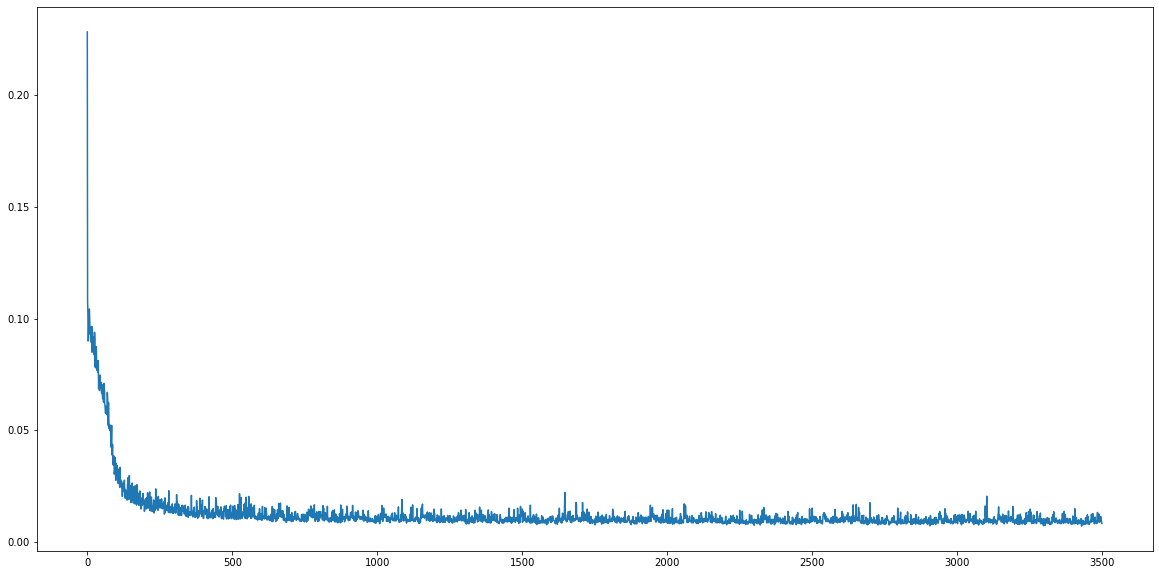

In [15]:
# train your network
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [32]:
# get a sample of test data again
net.cpu()
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


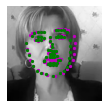

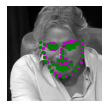

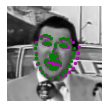

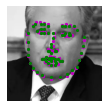

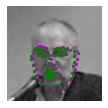

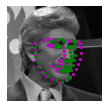

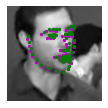

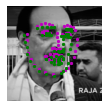

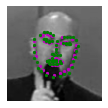

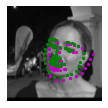

In [33]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [18]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_adam_SmoothL1_50_batchsize_500_epochs_12800_6400_1000_dense.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Experiments:  <br>

Tested locally using RTX 2060 GPU

| Sl No. | Model Architecture | Forward Function | Batch Size | Loss | Optimizer | Epochs | Training Loss (Avg. of final batch) | Training Time | Curve Summary |
| ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- |
| 1 | \*conf1 | \*forward | 10 | MSELoss | Adam (with default params) | 1 | 0.1812 | 21.4 | Sharp loss decrease till batch 30, then slow decrease until end of epoch 1 batch 340. Curve is a little noisy. |
| 2 | \*conf1 | \*forward | 20 | MSELoss | Adam (with default params) | 1 | 0.2386 | 20.2 | Sharp loss decrease till batch 30, then slow decrease until end of epoch 1 batch 170. Curve less noisy. |
| 3 | \*conf1 | \*forward | 50 | MSELoss | Adam (with default params) | 1 | 0.1832 | 18.2 | Sharp loss decrease till batch 30, then slow decrease until end of epoch 1 batch 70. Curve is a lot less noisy. |
| 4 | \*conf1 | \*forward | 50 | MSELoss | Adam (with default params) | 10 | 0.1157 | 189.4 | Sharp loss decrease till epoch 1 batch 30, then slow, gradual decrease until end of epoch 10 batch 70. Curve is a lot less noisy. |
| 5 | \*conf1 | \*forward | 50 | L1Loss | Adam (with default params) | 1 | 0.3383 | 18.0 | Sharp loss decrease till batch 30, then slow decrease until end of epoch 1 batch 70. Curve is a lot less noisy. |
| 6 | \*conf1 | \*forward | 50 | L1Loss | Adam (with default params) | 10 | 0.2487 | 176.8 | Sharp loss decrease till epoch 1 batch 30, then slow, gradual decrease until end of epoch 10 batch 70. Curve is a lot less noisy. |
| 7 | \*conf1 | \*forward | 50 | SmoothL1Loss | Adam (with default params) | 1 | 0.1004 | 21.6 | Sharp loss decrease till batch 30, then slow decrease until end of epoch 1 batch 70. Curve is a lot less noisy. |
| 8 | \*conf1 | \*forward | 50 | SmoothL1Loss | Adam (with default params) | 10 | 0.0480 | 174.5 | Sharp loss decrease till batch 30, then slow decrease until end of epoch 10 batch 70. Curve is a lot less noisy. Test output visualizations seems better than MSELoss and L1Loss outputs given all else same. |
| 9 | \*conf1 | \*forward | 10 | MSELoss | SGD lr=0.001 | 1 | 0.6545 | 20.4 | No apparent decrease in loss over the first epoch with SGD's lr=0.001. Curve is fluctuates a lot. |
| 10 | \*conf1 | \*forward | 10 | MSELoss | SGD lr=0.01 | 1 | 0.5305 | 20.1 | A little decrease in loss over the first epoch with SGD's lr=0.01. Curve is fluctuating a lot. |
| 11 | \*conf1 | \*forward | 50 | MSELoss | SGD lr=0.01 | 1 | 0.6179 | 18.3 | No apparent decrease in loss over the first epoch with SGD's lr=0.01 and batch size of 50. Curve is fluctuating a lot. |
| 12 | \*conf1 | \*forward | 50 | MSELoss | SGD lr=0.01 | 10 | 0.2122 | 174.3 | Loss decrease slowly till end of epoch 4, then there is much sharper decline at the start of epoch 5, followed by slow decrease again. SGD even with lr=0.01 is taking a much longer time to converge compared to Adam. |
| 13 | \*conf1 | \*forward | 50 | SmoothL1Loss | Adam (with default params) | 50 | 0.2545 (less than 0.2 for last 10 average) | 915.4 | Sharp loss decrease till batch 30, then relatively slow decrease until end of epoch 10 batch 70. Then very slow and gradual decline till epoch 50 batch 70. Curve is a lot less noisy. Test output visualizations seems quite good. |
| 14 | **\*conf2** | \*forward | 50 | SmoothL1Loss | Adam (with default params) | 50 | 0.0119 | 1024.4 | Same as above, but this architecture with gradual decrease of neurons in dense layers gives even better output visualizations on test data. Also, the loss is lower given all else kept the same. It takes slightly longer to train compared to the other architecture. |
| 15 | **\*conf2** | \*forward | 50 | SmoothL1Loss | Adam (with default params) | 500 | 0.0081 | 10691.3 | Not much change in error curve after about 100 epochs. Excellent output visualizations on test data. |

 <br>

**Note:** Different loss functions will give loss values at different ranges, e.g. MSELoss is calculated differently than L1Loss, so comparisons should not be made among different loss functions based on the Loss column above. Fair comparisons can only be made between rows having the same Loss function.

**\*conf1:**

Net( <br>
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1)) <br>
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) <br>
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)) <br>
  (fc1): Linear(in_features=12800, out_features=1000, bias=True) <br>
  (fc2): Linear(in_features=1000, out_features=1000, bias=True) <br>
  (output): Linear(in_features=1000, out_features=136, bias=True) <br>
  (dropout1_2): Dropout(p=0.1, inplace=False) <br>
  (dropout3_4_5): Dropout(p=0.3, inplace=False) <br>
  (dropout6_7): Dropout(p=0.5, inplace=False) <br>
) <br>

**\*conf2:**

Net( <br>
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1)) <br>
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) <br>
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1)) <br>
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)) <br>
  (fc1): Linear(in_features=12800, **out_features=6400**, bias=True) <br>
  (fc2): Linear(**in_features=6400**, out_features=1000, bias=True) <br>
  (output): Linear(in_features=1000, out_features=136, bias=True) <br>
  (dropout1_2): Dropout(p=0.1, inplace=False) <br>
  (dropout3_4_5): Dropout(p=0.3, inplace=False) <br>
  (dropout6_7): Dropout(p=0.5, inplace=False) <br>
) <br>

**\*forward:**

x = self.maxpool(F.relu(self.conv1(x))) <br>
        x = self.dropout1_2(x) <br>
        x = self.maxpool(F.relu(self.conv2(x))) <br>
        x = self.dropout1_2(x) <br>
        x = self.maxpool(F.relu(self.conv3(x))) <br>
        x = self.dropout3_4_5(x) <br>
        x = self.maxpool(F.relu(self.conv4(x))) <br>
        x = self.dropout3_4_5(x) <br>
        x = self.maxpool(F.relu(self.conv5(x))) <br>
        x = self.dropout3_4_5(x) <br>
        x = x.view(x.size(0), -1) <br>
        x = F.relu(self.fc1(x)) <br>
        x = self.dropout6_7(x) <br>
        x = F.relu(self.fc2(x)) <br>
        x = self.dropout6_7(x) <br>
        x = self.output(x) <br>

### Question 1: What optimization and loss functions did you choose and why?

**Answer**: I ran experiments (refer to the table above) using Stochastic Gradient Descent (SGD) and Adam optimization functions. Single epoch using SGD(lr=0.001) showed little or no noticeable change in loss over time (experiment #9). Then, increasing SGD's lr to 0.01 (experiment#10) gave a little decrease in loss over the first epoch. When ran over 50 epochs, SGD was slowly able to lower the loss over time (experiment#12). However, replacing SGD with Adam optimizer (with default params) and keeping all else same (experiment#4), I found that the loss decreased much faster. Also, the training time for Adam was only slightly higher compared to SGD. **Therefore, I used Adam optimizer since it takes less time to converge.**

I compared 3 loss functions which are all suitable for regression problems that produce continuous, numeric outputs, namely MSELoss, L1Loss and SmoothL1Loss. Since L1Loss and MSELoss use different formulas to calculate the loss (and SmoothL1Loss being a combination of the two), meaningful comparisons cannot be made by only looking at the loss numbers. So, instead I ran experiments using Adam optimizer, a batch size of 50 and for a total of 10 epochs for each of the 3 loss functions (experiments #4,6,8), and then looked at the output visualizations on test data (predicted vs true keypoints). SmoothL1Loss gave the best outputs on test data (at least visually for a few batches) and it also took slightly less time to train compared to L1Loss and MSELoss. **Hence, I chose SmoothL1Loss function.**

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I brought the image down to reasonable size using combinations of Conv2d and MaxPool2d filter layers before using a series of Dense layers. It required 5 Conv2d+MaxPool2d layers to bring the image dimension down to 5-by-5. Doubling the number of filters at each such layer gave 32 * 2^4 = 512 filters before the first Dense layer. So the first Dense layer consisted of 512\*5\*5 = 12800 nodes. I also used Dropoff between each layer in order to reduce overfitting (increasing the dropoff probability gradually in later layers). I only tested two architectures by only varying `in_features` of the second-last Dense layer. At first, I used 1000 nodes for the second-last Dense layer (experiments #1 to #13). However, I wanted to test how the loss trend and the output results differ if I increase `in_features` of the second-last layer from 1000 to 6400 (experiments #14,15). Comparing experiments #13 and #14 by keeping everything else constant, **I found that the variant with `in_features=6400` in the second-last Dense layer resulted in a much lower training loss, and it only took slightly longer to train. Hence, I chose the architecture from experiments #14 (conf2 in above table).**

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: For the batch size, I ran experiments using batch sizes of 10, 20 and 50. The loss fluctuates less over time for larger batch sizes, and the training time also decreased slightly. Otherwise, I could not identify any other significant differences for the limited number of experiments that I could run. I decided to go with batch size of 50 because a larger batch size gave much smoother loss trends over time, which made the loss curve a little easier to interpret, especially for initial experiments where I used lower number of epochs. Also, the computer faced no difficulties in performing the training steps when using **batch size of 50.**

I initially ran quick experiments for combinations of different architectures, batch sizes, optimizer and loss functions using a single epoch. Then, I gradually increased the epoch to 10 to finalize my selection of batch size and optimizer and loss functions. Then, in experiments #13 and #14, I used 50 epochs to select the final architecture. Then, using the final model, I intentionally ran a final experiment (#15) for 500 epochs to see when the loss stops decreasing. For my setup, the loss does not decrease much after about 100 epochs. Note that I ran all the 15 experiments on my laptop that had RTX 2060 GPU. So, I have chosen to **run the training for 100 epochs in the Udacity computing environment.**

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.39439693  0.2929459   0.22777402  0.2729185   0.38738352]
 [-0.10190109 -0.11828624 -0.10842148 -0.06440976  0.0746287 ]
 [-0.13881098  0.00473302 -0.02942102 -0.29513848 -0.07238881]
 [-0.02636933 -0.3320903   0.02562695 -0.14918205 -0.31628248]
 [-0.03367563  0.02512935 -0.02983792 -0.12093484 -0.12790506]]
(5, 5)


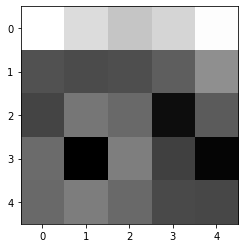

In [79]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 10

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

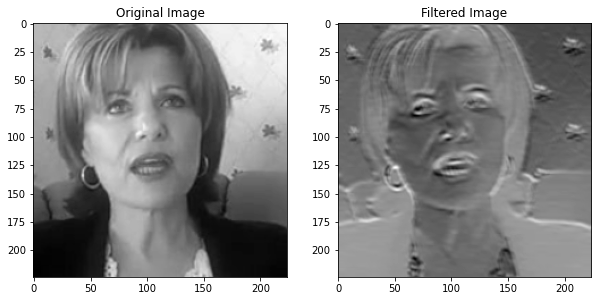

In [80]:
import cv2

##TODO: load in and display any image from the transformed test dataset
image = test_images[0].data
image = np.squeeze(image.numpy())
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
ax.set_title('Original Image')

ax.imshow(image, cmap='gray')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
ax = plt.subplot(1, 2, 2)
ax.set_title('Filtered Image')
filtered_image = cv2.filter2D(image, -1, w[filter_index][0])
ax.imshow(filtered_image, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The 5-by-5 filter that I selected from the first convolutional layer has high values on the first row and much lower values in the other 4 rows. From this, I could tell that this filter will probably detect horizontal features. The filtered image contained bright spots near the upper and lower eyelids, above the nostrils, on the upper lip and around the chin and shoulders, thus, confirming that the filter helps to detect horizontal edges. More specifically, for this particular task, it partially facilitates the model in its learning process to detect the correct keypoints near these brighter spots.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!